# Tarea Titanic

Usando el datasets:​ https://www.kaggle.com/c/titanic​

Implemente el mejor clasificador que usted considere conveniente de los vistos en clase. (LR, KNN, SVM) (iterar hiperparámetros)

Sustentar por qué es el mejor (MCC, AUC-ROC, "ACC :( este NO " )

In [258]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

Primero observamos el contenido de nuestro data set, el de entrenamiento y el de testeo.

In [259]:
train = pd.read_csv(r"train.csv") 
test = pd.read_csv(r"test.csv")
test_ids = test["PassengerId"]
train.head(-5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S


Luego empezamos con todo el adecuamiento del data set, eliminando valores NaN, Null, etc o reemplazandolos por la media, tambien pasando características como el género de palabras a números.

In [260]:
print("Valores nulos en train: \n", train.isna().sum(),"\n")

Valores nulos en train: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 



Se eliminan las columnas que no aportan al dataset

In [261]:
train.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1, inplace = True) #Las columnas inutiles se eliminan  
print(train.head(), "\n") 
train.isna().sum()
#Se rellenan los ceros de "Fare" con la media
train['Fare'] = train['Fare'].replace(0, train['Fare'].mean())
#Se rellenan los nulos con su media
train['Age'].fillna(train['Age'].mean(), inplace = True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)
#Revisando los vacios
print(train.isna().sum())
train.head()

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S 

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [262]:
train['Sex'] = train['Sex'].apply(lambda val: 1 if val == 'male' else 0) #1 para hombre, 0 para mujer 
train['Embarked'] = train['Embarked'].map({'S' : 0, 'C': 1, 'Q': 2}) #Abordaje 
print(train.head(), "\n")
train.describe()

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    1  22.0      1      0   7.2500         0
1         1       1    0  38.0      1      0  71.2833         1
2         1       3    0  26.0      0      0   7.9250         0
3         1       1    0  35.0      1      0  53.1000         0
4         0       3    1  35.0      0      0   8.0500         0 



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.746366,0.361392
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.514272,0.635673
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,4.012500,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000
50%,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,15.100000,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,32.204208,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


Realizamos el mismo procedimiento para los datos del Test

In [263]:
test.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1, inplace = True) #Las columnas inutiles se eliminan  
print(test.head(), "\n") 
test.isna().sum()
#Se rellenan los ceros de "Fare" con la media
test['Fare'] = test['Fare'].replace(0, test['Fare'].mean())
test['Fare'].fillna(test['Fare'].mean(), inplace = True)
#Se rellenan los nulos con su media
test['Age'].fillna(test['Age'].mean(), inplace = True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace = True)
#Revisando los vacios
print(test.isna().sum())
test.head()

test['Sex'] = test['Sex'].apply(lambda val: 1 if val == 'male' else 0) #1 para hombre, 0 para mujer 
test['Embarked'] = test['Embarked'].map({'S' : 0, 'C': 1, 'Q': 2}) #Abordaje 
print(test.head(), "\n")
test.describe()

   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  34.5      0      0   7.8292        Q
1       3  female  47.0      1      0   7.0000        S
2       2    male  62.0      0      0   9.6875        Q
3       3    male  27.0      0      0   8.6625        S
4       3  female  22.0      1      1  12.2875        S 

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    1  34.5      0      0   7.8292         2
1       3    0  47.0      1      0   7.0000         0
2       2    1  62.0      0      0   9.6875         2
3       3    1  27.0      0      0   8.6625         0
4       3    0  22.0      1      1  12.2875         0 



,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.636364,30.272590,0.447368,0.392344,35.798062,0.464115
std,0.841838,0.481622,12.634534,0.896760,0.981429,55.785702,0.685516
min,1.000000,0.000000,0.170000,0.000000,0.000000,3.170800,0.000000
25%,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800,0.000000
50%,3.000000,1.000000,30.272590,0.000000,0.000000,14.479150,0.000000
75%,3.000000,1.000000,35.750000,1.000000,0.000000,31.634400,1.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000


Y por último antes de empezar el entrenamiento de nuestro algortimo revisamos algunas estadísticas del dataset 

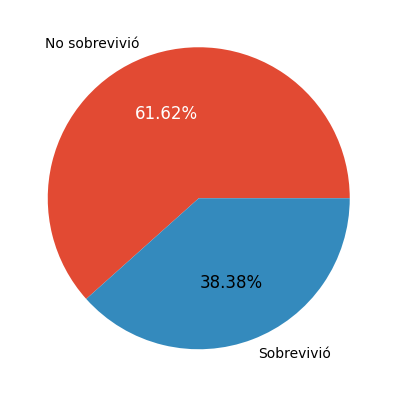

In [ ]:
values = train['Survived'].value_counts()
labels = ['No sobrevivió', 'Sobrevivió']
fig, ax = plt.subplots(figsize = (5, 5), dpi = 100)
explode = (0, 0.06)
patches, texts, autotexts = ax.pie(values, labels = labels, autopct = '%1.2f%%')
plt.setp(texts, color = 'black')
plt.setp(autotexts, size = 12, color = 'white')
autotexts[1].set_color('black')
plt.show()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


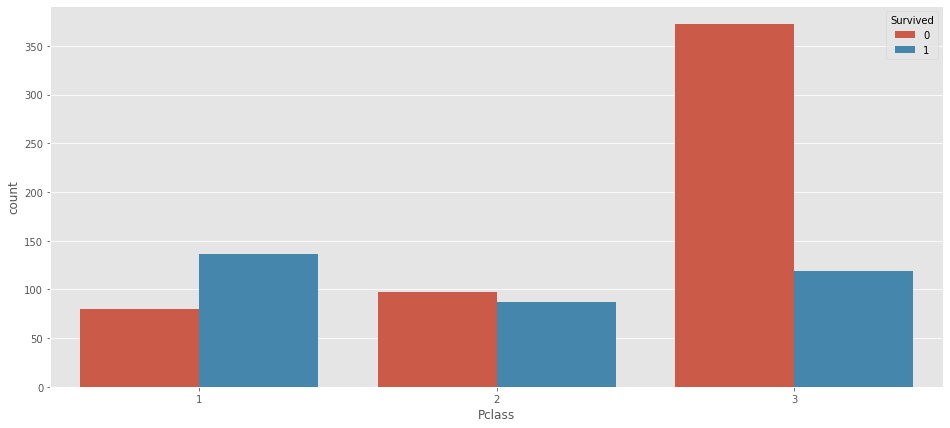

In [ ]:
print(train.groupby(['Pclass', 'Survived'])['Survived'].count(), "\n")
plt.figure(figsize = (16, 7))
sb.countplot('Pclass', hue = 'Survived', data = train) 
plt.show()

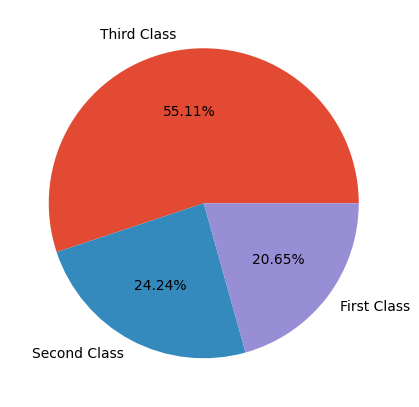

In [ ]:
values = train['Pclass'].value_counts() 
labels = ['Third Class', 'Second Class', 'First Class'] 
explode = (0, 0, 0.08)
fig, ax = plt.subplots(figsize = (5, 6), dpi = 100) 
patches, texts, autotexts = ax.pie(values, labels = labels, autopct = '%1.2f%%')

**Relación entre posibilidad de sobrevivir y clase**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


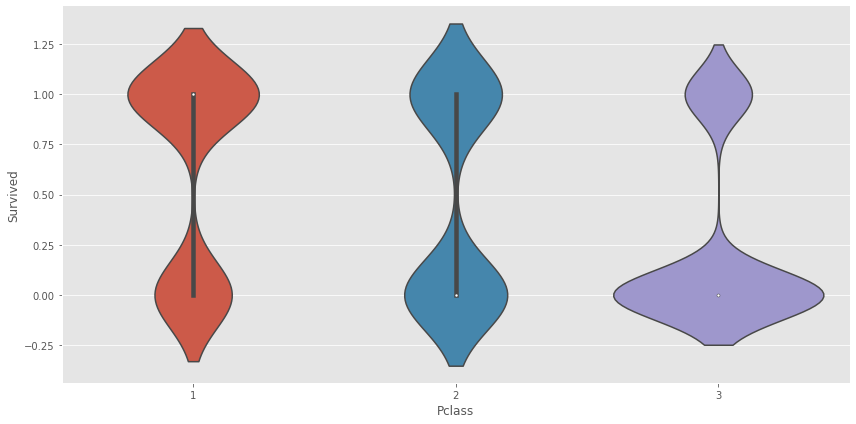

In [ ]:
plt.setp(texts, color = 'black')
plt.setp(autotexts, size = 13, color = 'white')
autotexts[2].set_color('black')
plt.show()
sb.catplot('Pclass', 'Survived', kind = 'violin', data = train,height = 6, aspect = 2)
plt.show() 

**Relación entre lugar de abordaje y supervivencia**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


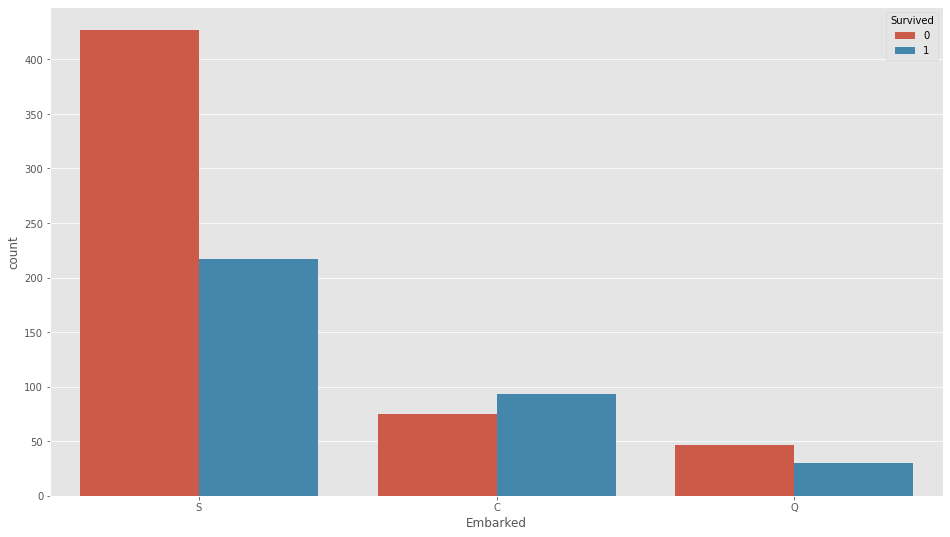

In [ ]:
sb.countplot('Embarked', hue = 'Survived', data = train)
plt.show()

**Relación entre lugar de abordaje, supervivencia y sexo**

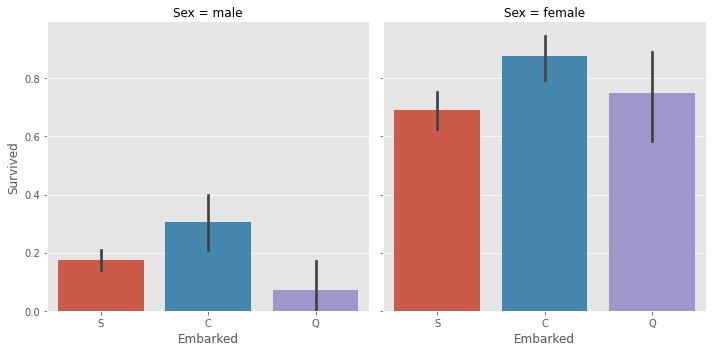

In [ ]:
sb.catplot(x = 'Embarked', y = 'Survived', kind = 'bar', data = train, col = 'Sex')
plt.show()

In [ ]:
print(train['Age'].value_counts(), "\n")

29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
            ... 
55.500000      1
53.000000      1
20.500000      1
23.500000      1
0.420000       1
Name: Age, Length: 89, dtype: int64 



Empezando nuestro entrenamiento

In [264]:
X = train[['Sex','Age','SibSp','Parch','Pclass','Fare','Embarked']].values
y = train['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.3)

scaler = StandardScaler() #Se escalizan los datos
scaler.fit(X_train) #El fit de los datos se hace con el conjunto de entrenamiento!
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**REGRESIÓN LOGÍSTICA**

In [ ]:
log = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred = log.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       168
           1       0.73      0.72      0.72       100

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268



In [ ]:
matthews_corrcoef(y_test,pred)

0.5604377974938483

In [ ]:
score = log.predict_proba(X_test)
roc_auc_score(y_test,score[:, 1])

0.8494642857142857

**KNN**

In [ ]:
k_range = range(1, int(np.sqrt(len(y_train))))
print(k_range)
#por ejemplo euclidean. manhattan. chebyshev. minkowski. wminkowski. seuclidean. mahalanobis. hamming
#import sklearn
#sorted(sklearn.neighbors.VALID_METRICS['brute'])
distance='minkowski'#podemos hacer un for que recorra las distancias que queremos probar en un enfoque grid-search.

ACC=[]
MCC=[]
TPR=[]
FPR=[]
AUC=[]

for k in k_range:#por ahora variemos K, 
    knn = KNeighborsClassifier(n_neighbors = k,weights='distance',metric=distance, metric_params=None,algorithm='brute')
    #knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_predicted=knn.predict(X_test)

    y_score=knn.predict_proba(X_test)
    #Les toca hacer:
    #Hallar: Accuracy
    ACC.append(knn.score(X_test, y_test))
    #MCC 
    MCC.append(matthews_corrcoef(y_test,y_predicted))
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
    #TPR
    #Ustedes buscan
    TPR.append(recall_score(y_test,y_predicted))
    #FPR esuno menos TNR no TPR
    #Ustedes buscan
    tn, fp, fn, tp = confusion_matrix(y_test,y_predicted).ravel()
    #FPR= FP/N =FP/(FP+TN)
    FPR.append(fp/(fp+tn))
    # AUC de la ROC
    #AUC.append(y_score[:, 1])
    AUC.append(roc_auc_score(y_test,y_score[:, 1]))

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.5f)' % roc_auc_score(y_test,y_score[:, 1]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic. ROC')
    plt.legend(loc="lower right")
    plt.show()

[0.753731343283582, 0.7649253731343284, 0.7798507462686567, 0.7798507462686567, 0.7873134328358209, 0.7798507462686567, 0.7873134328358209, 0.7798507462686567, 0.7873134328358209, 0.7947761194029851, 0.7910447761194029, 0.7910447761194029, 0.7985074626865671, 0.8059701492537313, 0.7985074626865671, 0.7947761194029851, 0.8059701492537313, 0.8022388059701493, 0.8134328358208955, 0.8022388059701493, 0.8059701492537313, 0.8097014925373134, 0.8059701492537313]


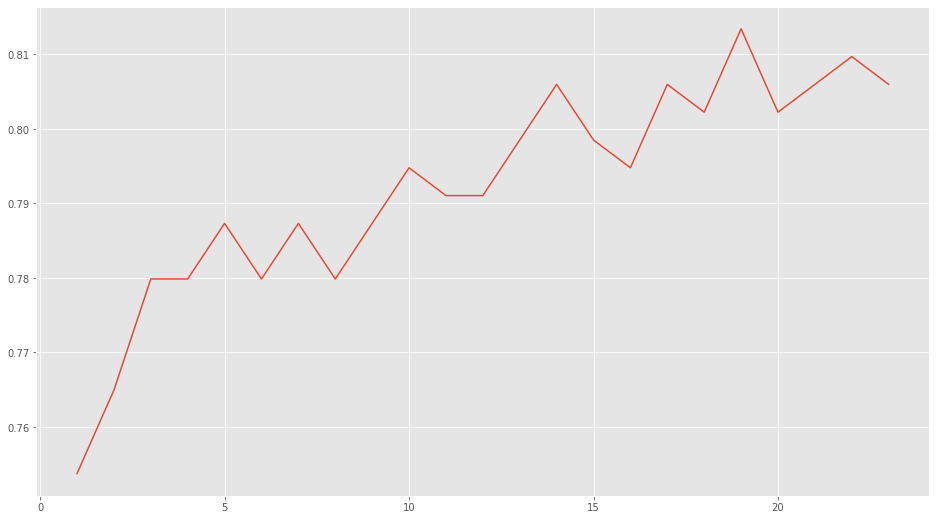

In [ ]:
print(ACC)
plt.figure()
plt.plot(k_range,ACC)
plt.show()

[0.4735714285714286, 0.4927632817554276, 0.5234824282445948, 0.5234824282445948, 0.5427372558705581, 0.5266827763370802, 0.5427372558705581, 0.5266827763370802, 0.5396900634998572, 0.5558976987551195, 0.5471346231760836, 0.5471346231760836, 0.5622550923689653, 0.5796328676377837, 0.5622550923689653, 0.5558976987551195, 0.5796328676377837, 0.5734060269376788, 0.5958819898686336, 0.5734060269376788, 0.5808217751441436, 0.5895345759741291, 0.5808217751441436]


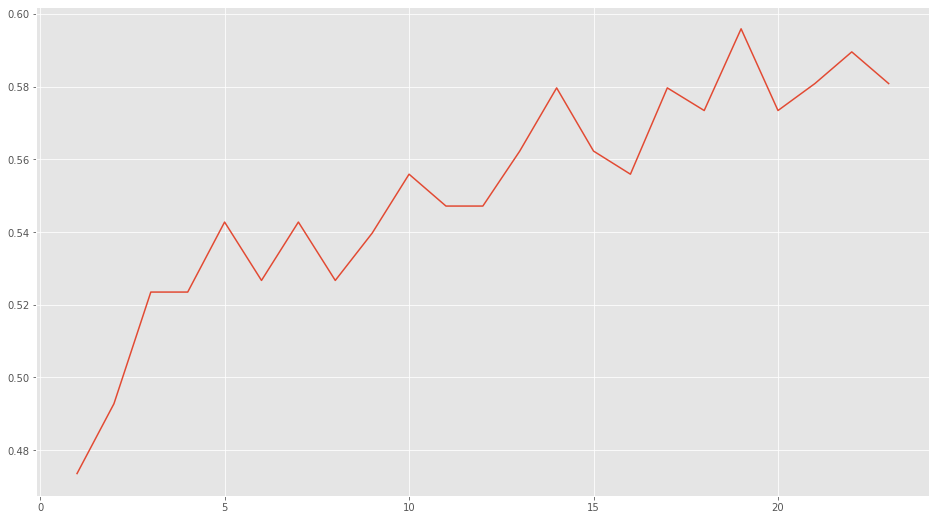

In [ ]:
print(MCC)
plt.figure()
plt.plot(k_range,MCC)
plt.show()

[0.7367857142857143, 0.7894940476190477, 0.8109226190476191, 0.8389285714285714, 0.8422321428571429, 0.8420238095238095, 0.8418452380952381, 0.8418154761904764, 0.8408333333333333, 0.8453571428571429, 0.8497023809523809, 0.8535416666666666, 0.8585714285714285, 0.8614285714285713, 0.8600595238095237, 0.8596428571428573, 0.8624107142857143, 0.8645238095238096, 0.8660416666666666, 0.8678273809523811, 0.8681249999999998, 0.8675297619047617, 0.8659821428571428]


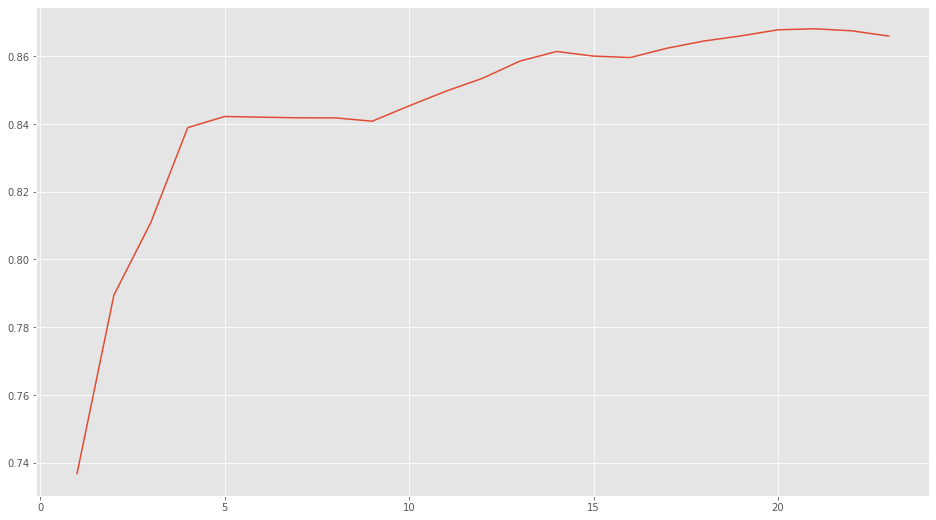

In [ ]:
print(AUC)
plt.figure()
plt.plot(k_range,AUC)
plt.show()

**SVM**

In [269]:
kernels=['linear', 'poly', 'rbf', 'sigmoid']
#lineal
#Kernel=0
#msv = svm.SVC(kernel=kernels[Kernel])

#polinomial cuadrático
#Kernel=1
#msv = svm.SVC(kernel=kernels[Kernel],degree=2)

#polinomial cúbico
#Kernel=1
#msv = svm.SVC(kernel=kernels[Kernel],degree=3)
#rbf 
Kernel=2
msv = svm.SVC(kernel=kernels[Kernel],C=0.001)
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

msv.fit(X_train, y_train)

SVC(C=0.001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


matthews_corrcoef 0.0
Accuracy 0.6268656716417911


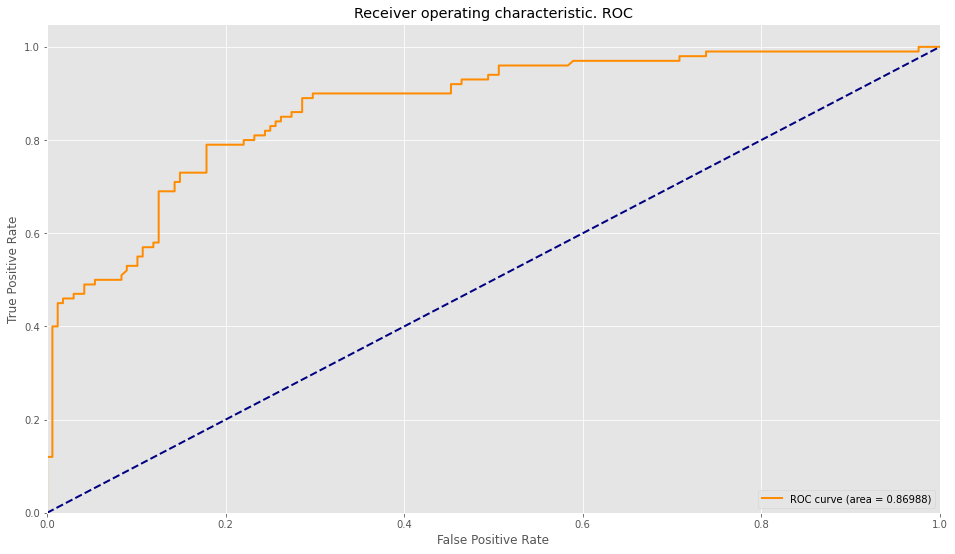

In [270]:
y_test_predicted = msv.predict(X_test)
y_test_scores = msv.decision_function(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("matthews_corrcoef", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)

fpr,tpr,thresholds = roc_curve(y_test, y_test_scores)
roc_auc=roc_auc_score(y_test, y_test_scores)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic. ROC')
plt.legend(loc="lower right")
plt.show()

Modificando la regularización (C) del método obtenemos la mejor evaluación de la ROC para SVM y de todos los métodos de clasificación implementados.

Por ello el método a evaluar en la competición de Kaggle sera el de Máquinas de soporte vectorial.

In [280]:
pre = msv.predict(test)
df = pd.DataFrame({"PassengerId": test_ids.values,"Survived": pre})
df.to_csv("submission.csv", index=False)